# Finetune Mask R-CNN with `torchvision`

Heavily based on the [TorchVision Object Detection Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) with the following updates:

- Uses the [MinneApple](https://rsn.umn.edu/projects/orchard-monitoring/minneapplehttps://rsn.umn.edu/projects/orchard-monitoring/minneapple) fruit detection dataset.
- Updated the dataset implementation to follow the same conventions as other `torchvision` datasets e.g. subclassing `VisionDataset`, using type hints, including `train` and `download` flags, and to use `torchvision` utilities where possible (e.g. `mask_to_boxes`).
- Save the model to disk after training, and load it from disk for inference.
- Render images with ground truth and predicted masks and bounding boxes overlaid.
- Removed the test forward pass and some comments.

Uses the following versions:

- `pycocotools==2.0.4`
- `torch==1.11.0`
- `torchvision==0.12.0+cu113`

## Step 1. Define the dataset

In [1]:
from pathlib import Path
from typing import Any, Callable, Dict, Optional, Tuple

import numpy as np
import torch
from PIL import Image
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import download_and_extract_archive
from torchvision.ops import masks_to_boxes
from torchvision.transforms.functional import to_tensor


class MinneApple(VisionDataset):
    url = "https://conservancy.umn.edu/bitstream/handle/11299/206575/detection.tar.gz"
    md5 = "d24a2f70144f1a3c5a52ffef66c50630"
    data_dir_name = "detection"
    image_dir_name = "images"
    mask_dir_name = "masks"

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
        download: bool = False,
    ):
        super().__init__(
            root,
            transform=transform,
            target_transform=target_transform,
            transforms=transforms,
        )
        self.train = train

        # Check if the expected directory structure exists
        data_dir = Path(root) / self.data_dir_name
        location = "train" if self.train else "test"
        split_dir = data_dir / location
        image_dir = split_dir / self.image_dir_name
        mask_dir = split_dir / self.mask_dir_name
        if not all(x.is_dir() for x in (image_dir, mask_dir)):
            if download:
                download_and_extract_archive(self.url, root, md5=self.md5)
            else:
                raise RuntimeError("Dataset not found. You may use download=True to download it.")

        # Find all images and corresponding masks
        self.image_paths = list(sorted(image_dir.glob("*.png")))
        if self.train:
            self.mask_paths = [mask_dir / x.name for x in self.image_paths]
            assert all(x.exists() for x in self.mask_paths), "Missing mask files."

    def _load_target(self, index: int) -> Dict[str, Any]:
        int_mask = to_tensor(Image.open(self.mask_paths[index]))

        # Convert mask from a 2D image array with objects represented by increasing
        # integers to a 3D boolean array
        # Source: https://pytorch.org/vision/stable/auto_examples/plot_repurposing_annotations.html
        object_ids = torch.unique(int_mask)
        # Ignore the background object (object_id == 0)
        object_ids = object_ids[1:]
        masks = int_mask == object_ids[:, None, None]

        boxes = [
            [x1, y1, x2, y2]
            for x1, y1, x2, y2 in masks_to_boxes(masks)
            # Ignore bad bounding boxes
            if x2 > x1 and y2 > y1
        ]

        # Create the object detection target in its expected format
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Assume single label
        labels = torch.ones((masks.shape[0],), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # Assume iscrowd is always false
        iscrowd = torch.zeros((masks.shape[0],), dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }
        return target

    def __getitem__(self, index: int) -> Tuple[Image.Image, Optional[Dict[str, Any]]]:
        image = Image.open(self.image_paths[index]).convert("RGB")
        target = self._load_target(index) if self.train else None
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        return image, target

    def __len__(self) -> int:
        return len(self.image_paths)

In [2]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

def draw_seg(img, target):
    if not isinstance(img, torch.Tensor):
        img = to_tensor(img)
    img = (img * 255).to(torch.uint8)
    masks = target["masks"].squeeze(1).to(bool)
    boxes = target["boxes"]
    colors = ["white"] * len(masks)
    result = img
    result = draw_segmentation_masks(result, masks, colors=colors, alpha=0.3)
    result = draw_bounding_boxes(result, boxes, colors=colors)
    return result

def show(img):
    plt.figure(figsize=(12, 12))
    plt.imshow(to_pil_image(img))

In [3]:
root = "data"
dataset = MinneApple(root, download=True)
dataset

Dataset MinneApple
    Number of datapoints: 670
    Root location: data

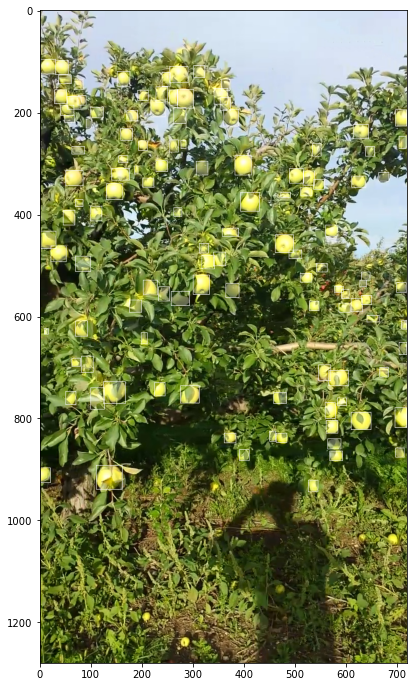

In [4]:
sample_idx = torch.randint(len(dataset), size=(1,)).item()
img, target = dataset[sample_idx]
show(draw_seg(*dataset[sample_idx]))

## Step 2. Fine-tune Mask R-CNN

See the [reference detection training script]( https://github.com/pytorch/vision/blob/main/references/detection/train.pyhttps://github.com/pytorch/vision/blob/main/references/detection/train.py) for a far more extensive training setup.

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn


def get_instance_segmentation_model(num_classes, hidden_layer=256):
    model = maskrcnn_resnet50_fpn(pretrained=True)
    # Replace the ROI head's box predictor with the new num_classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # Replace the ROI head's mask predictor with the new num_classes
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

In [6]:
%%bash

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.12.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 9b5a3fecc Add Python-3.10 (build and test) (#5420) (#5579)


In [7]:
from engine import train_one_epoch, evaluate
import transforms as T
import utils


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
val_size = 50

dataset = MinneApple(root, transforms=get_transform(train=True))
dataset_val = MinneApple(root, transforms=get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-val_size])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-val_size:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = get_instance_segmentation_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [10]:
num_epochs = 1

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_val, device=device)

Epoch: [0]  [  0/310]  eta: 0:25:28  lr: 0.000021  loss: 4.4778 (4.4778)  loss_classifier: 0.6927 (0.6927)  loss_box_reg: 0.8377 (0.8377)  loss_mask: 2.0712 (2.0712)  loss_objectness: 0.6935 (0.6935)  loss_rpn_box_reg: 0.1826 (0.1826)  time: 4.9304  data: 1.2880  max mem: 2600
Epoch: [0]  [ 10/310]  eta: 0:05:56  lr: 0.000183  loss: 3.3726 (3.6361)  loss_classifier: 0.6788 (0.6496)  loss_box_reg: 0.8270 (0.7441)  loss_mask: 1.1238 (1.4178)  loss_objectness: 0.5658 (0.6471)  loss_rpn_box_reg: 0.1826 (0.1774)  time: 1.1887  data: 0.1344  max mem: 3358
Epoch: [0]  [ 20/310]  eta: 0:04:51  lr: 0.000344  loss: 2.4842 (2.8988)  loss_classifier: 0.5053 (0.5465)  loss_box_reg: 0.6296 (0.6474)  loss_mask: 0.9356 (1.0557)  loss_objectness: 0.3309 (0.4946)  loss_rpn_box_reg: 0.1371 (0.1545)  time: 0.8102  data: 0.0182  max mem: 3358
Epoch: [0]  [ 30/310]  eta: 0:04:21  lr: 0.000506  loss: 1.6883 (2.4588)  loss_classifier: 0.3509 (0.4739)  loss_box_reg: 0.5195 (0.6003)  loss_mask: 0.4949 (0.8517) 

Save the model for inference.

In [11]:
outputs_dir = Path("outputs")
outputs_dir.mkdir(exist_ok=True)
model_path = outputs_dir / "torch_model.pt"
torch.save(model.state_dict(), model_path)

## Step 3. Inference

Load the model for inference.

In [12]:
inference_model = get_instance_segmentation_model(num_classes)
inference_model.load_state_dict(torch.load(model_path))
inference_model.to(device)
_ = inference_model.eval()

In [13]:
img, target = dataset_val[0]
with torch.no_grad():
    [prediction] = inference_model([img.to(device)])

In [14]:
from torchvision.utils import make_grid

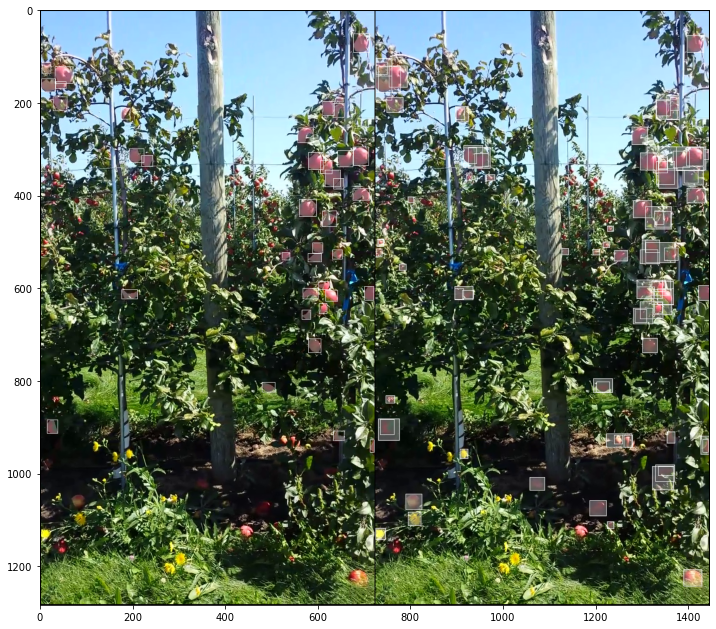

In [15]:
grid = make_grid(
    [
        draw_seg(img, target),
        draw_seg(img, prediction)
    ]
)
show(grid)